In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
pd.set_option('display.max_rows',2000)

%run ../shared_datasets/charlie_functions.py
%run ../shared_datasets/clean_dataframe.py

In [2]:
raw_data = pd.read_csv('/Users/schlinkertc/Flatiron/projects/mod4_project/developer_survey_2019/survey_results_public.csv')

dataframe_class = CleanDataframe(raw_data)
df = dataframe_class.cleaned_df

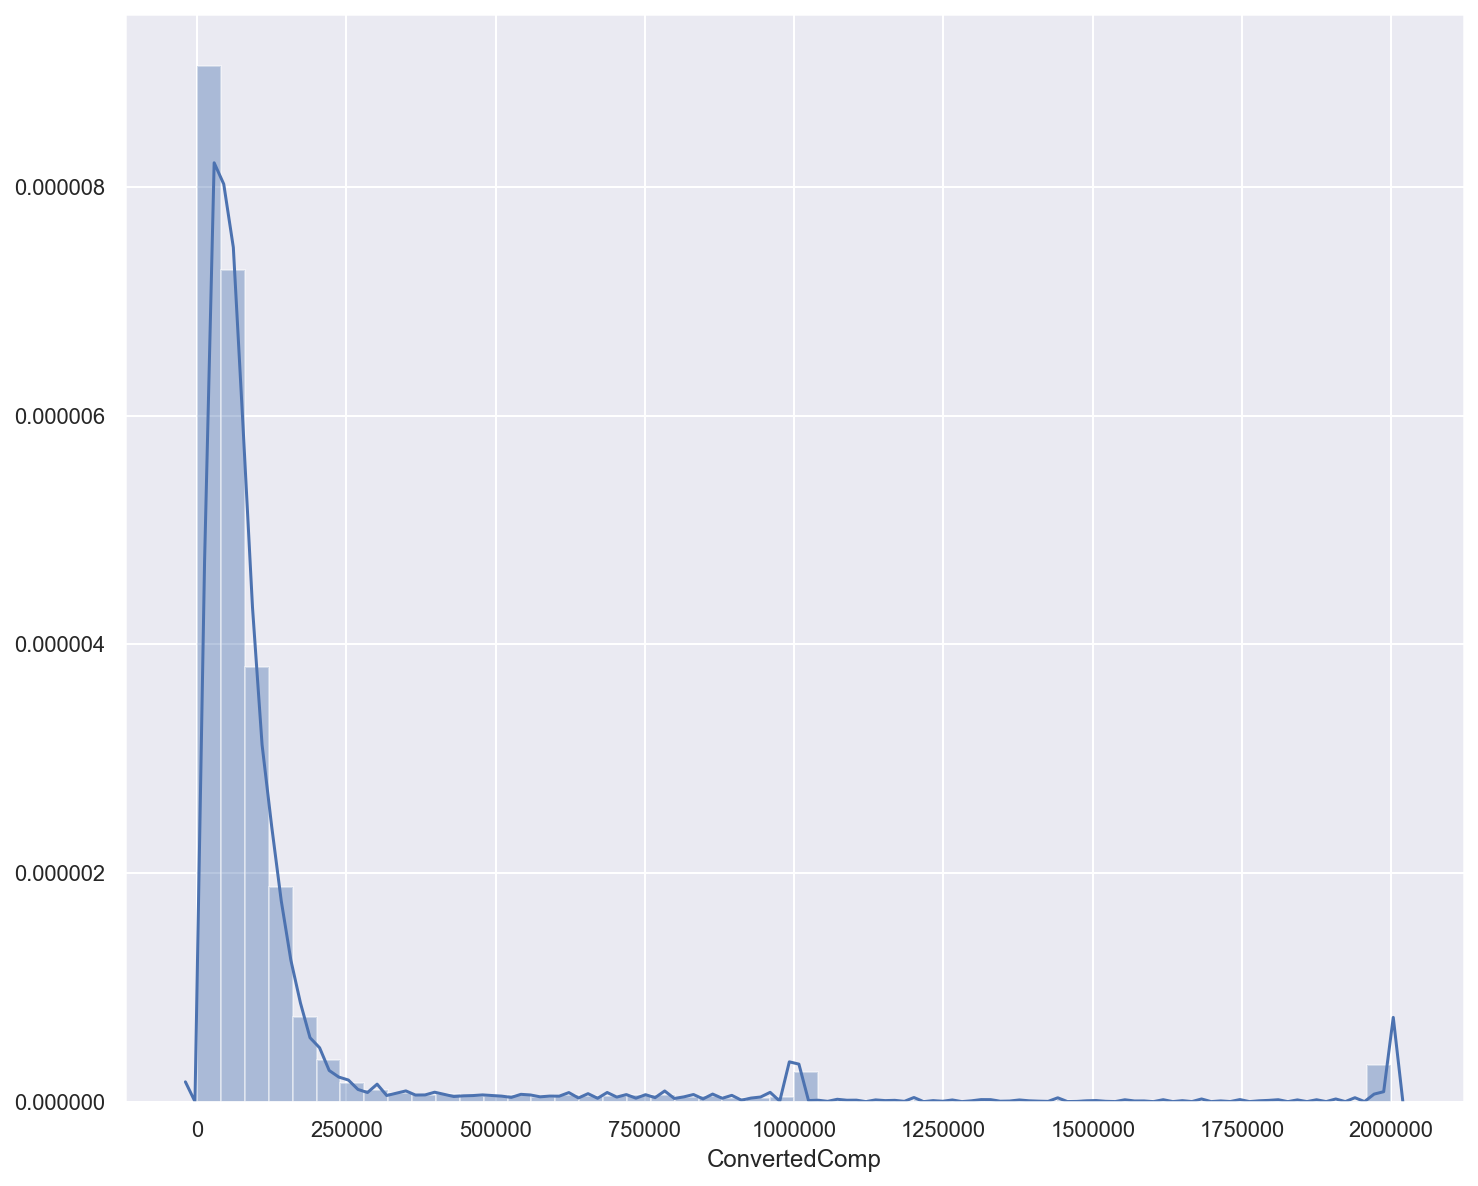

In [3]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

sns.distplot(raw_data['ConvertedComp'].dropna())

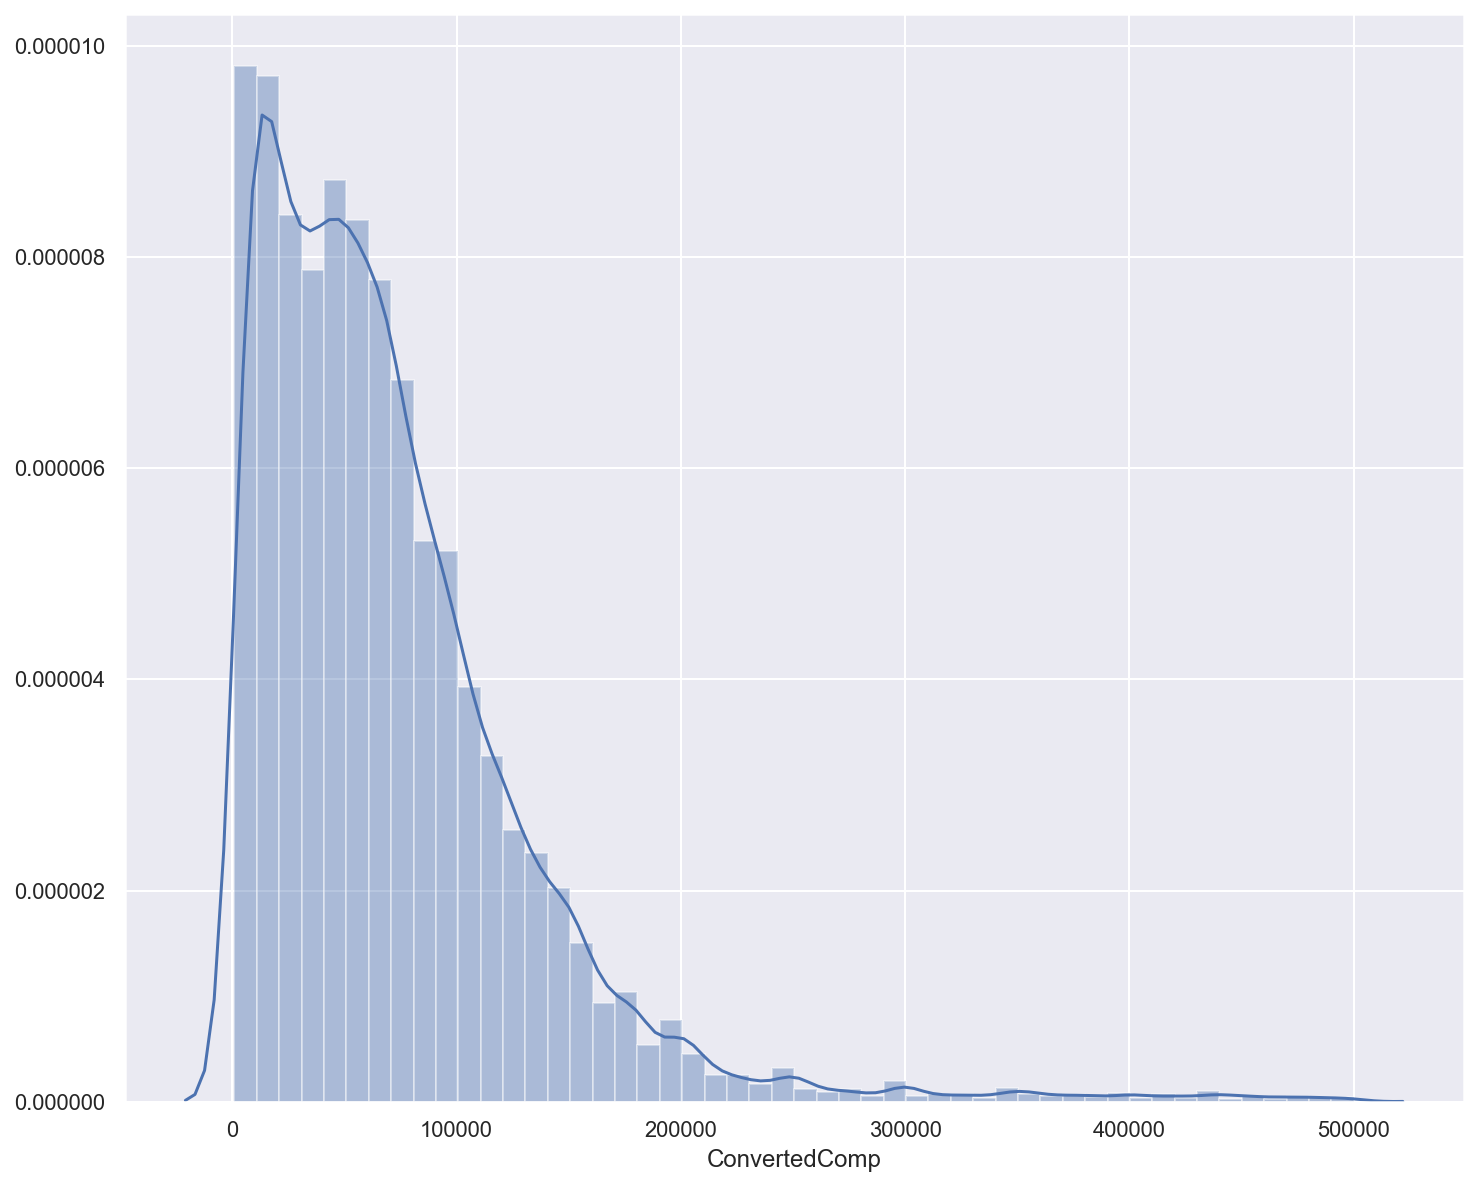

In [4]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

sns.distplot(df['ConvertedComp'])

In [5]:
temp = df[(df['ConvertedComp']>10000) & (df['ConvertedComp']<250000)]

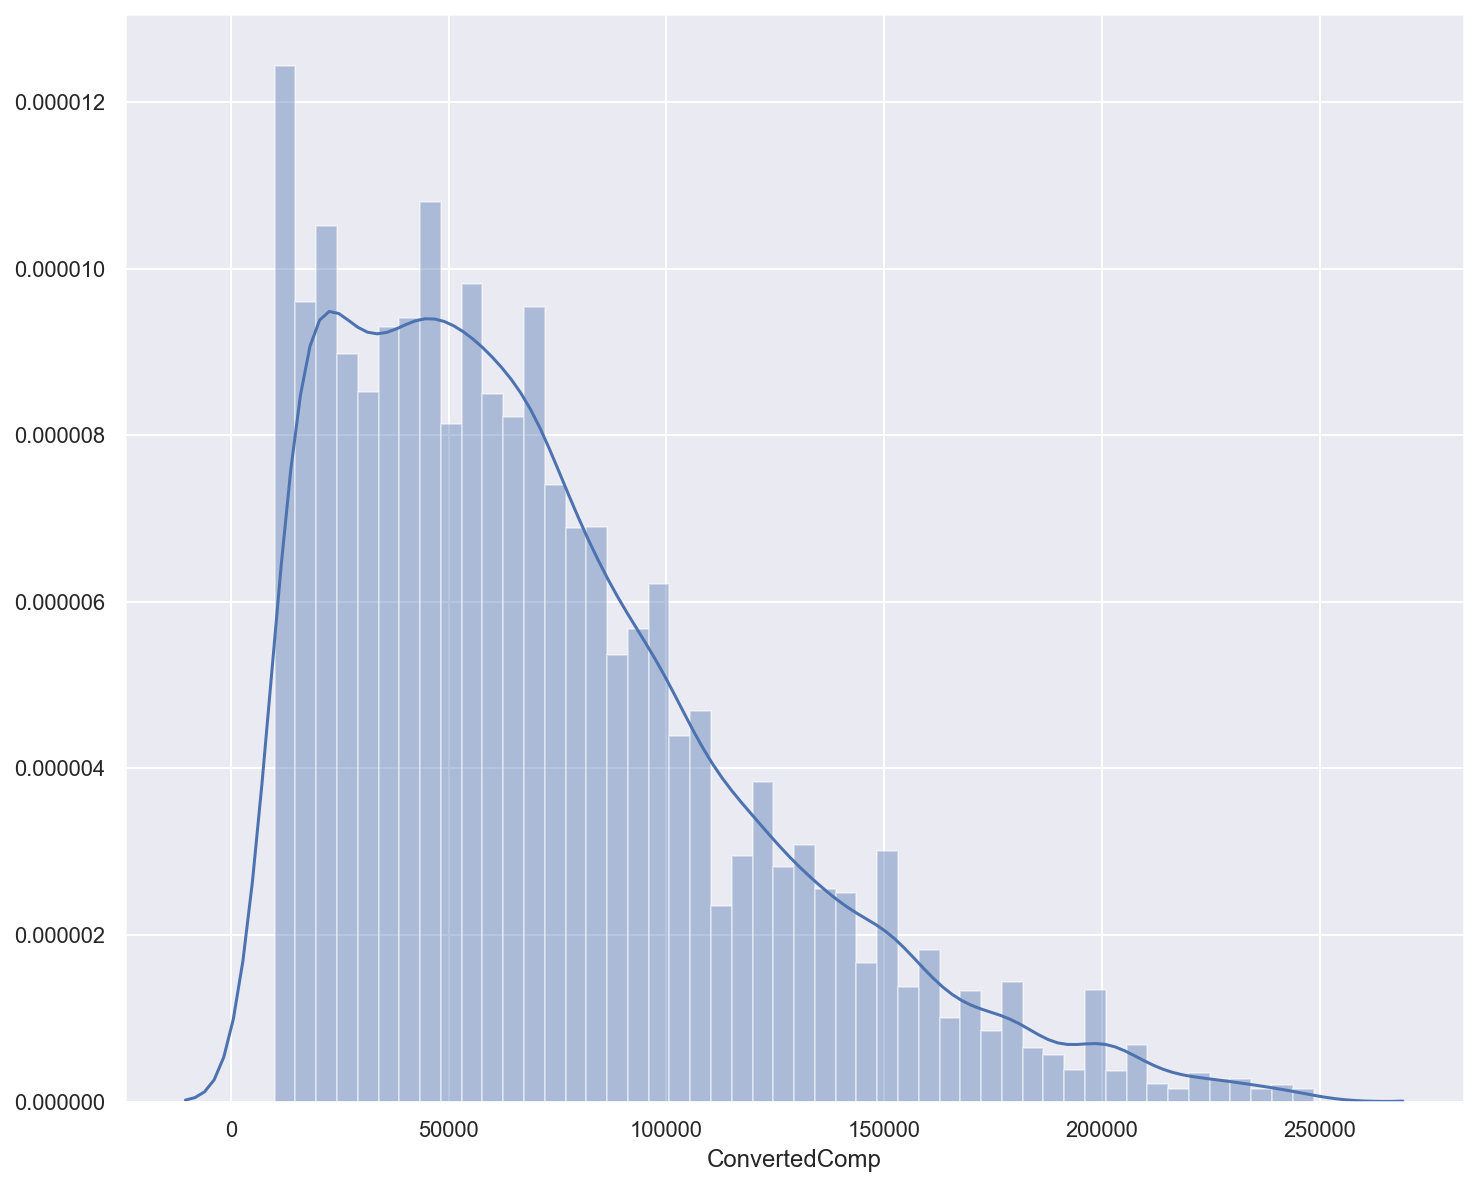

In [6]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

sns.distplot(temp['ConvertedComp'])

In [7]:
X = df.drop(columns=['Respondent','ConvertedComp'])
Y = df['ConvertedComp']

sm_performance,sm_variables,sm_outcomes = sm_OLS(X,Y)
#sm_performance['Value'] = sm_performance['Value'].apply(lambda x: round(x,10))

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [8]:
Xtemp = temp.drop(columns=['Respondent','ConvertedComp'])
Ytemp = temp['ConvertedComp']

temp_performance,temp_variables,temp_outcomes = sm_OLS(Xtemp,Ytemp)

In [9]:
sm_performance.transpose()

,MSE,MSE_resid,RMSE,R^2,R^2_adjusted,F-stat,AIC,BIC
Value,1.427752e+11,2.127930e+09,46129.48966,0.457783,0.45096,67.095843,507082.849175,509148.49027


In [10]:
temp_performance.transpose()

,MSE,MSE_resid,RMSE,R^2,R^2_adjusted,F-stat,AIC,BIC
Value,1.004529e+11,7.988160e+08,28263.333964,0.634374,0.629329,125.752237,434101.460873,436090.390822


In [11]:
def ols_recursion(x_values,y_values):
    
    temp_performance,temp_variables,temp_outcomes = sm_OLS(x_values,y_values)
    print(len((temp_variables.index.tolist())))
    
    to_drop = temp_variables[temp_variables['P>|t|']>.05].index.tolist()
    try:
        to_drop.remove('const')
    except:
        to_drop
    
    print(len(to_drop))
    if len(to_drop)>0:
        print('flip')
        x_values.drop(columns=to_drop,inplace=True)
        ols_recursion(x_values,y_values)
    else:
        print('done')
    return sm_OLS(x_values,y_values)
    

In [12]:
a,b,c = ols_recursion(Xtemp,Ytemp)

294
139
flip
155
28
flip
127
6
flip
121
3
flip
118
0
done


In [13]:
a.transpose()

,MSE,MSE_resid,RMSE,R^2,R^2_adjusted,F-stat,AIC,BIC
Value,2.186926e+11,8.071898e+08,28411.085172,0.627761,0.625444,270.930785,434158.71727,435067.047483


In [14]:
b.sort_values('P>|t|',ascending=False)

,coef,std err,t,P>|t|,[0.025,0.975]
const,1987.0992,1364.713,1.456,0.145,-687.864,4662.062
Country_Serbia,-6543.8732,3296.856,-1.985,0.047,-13000.000,-81.730
Country_The former Yugoslav Republic of Macedonia,-15990.0000,7947.830,-2.012,0.044,-31600.000,-414.296
Country_Spain,-3301.0878,1625.766,-2.030,0.042,-6487.740,-114.436
SOVisitFreq_A few times per month or weekly,1728.6103,826.835,2.091,0.037,107.938,3349.283
Country_Viet Nam,-14360.0000,6780.284,-2.118,0.034,-27600.000,-1068.655
Country_Kenya,-10950.0000,5154.935,-2.125,0.034,-21100.000,-848.453
ResumeUpdate_Re-entry into the workforce,-4081.0432,1886.291,-2.164,0.031,-7778.349,-383.738
"JobSeek_I’m not actively looking, but I am open to new opportunities",1569.9456,726.609,2.161,0.031,145.725,2994.166
Country_Swaziland,63260.0000,28500.000,2.218,0.027,7363.131,119000.000


In [15]:
c

,Observed_values,Predicted_values,Residuals
13,57060.0,60212.577146,-3152.577146
16,65277.0,59547.827863,5729.172137
18,31140.0,33398.268288,-2258.268288
22,69000.0,103947.637147,-34947.637147
28,100000.0,131881.343380,-31881.343380
...,...,...,...
88296,13272.0,14073.793892,-801.793892
88298,120000.0,110341.602783,9658.397217
88301,110000.0,86348.572452,23651.427548
88323,180000.0,121189.821219,58810.178781
